# baseline NCA
基本caadria版本的cfd nca 

- 整張圖訓練 low resolution
- 先完成overfit

In [7]:
# 1. 標準庫
import sys
import os
import io
import json
import glob

# 2. 第三方套件
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
from keras import layers, models, optimizers, losses, metrics
import tqdm
from IPython.display import clear_output, display, HTML

# 3. 影片相關

import cv2

# 4. 設定 project 路徑（依你本機路徑調整）
project_root = "C:/Users/GAI/Desktop/Scott/NCA_Research"
if project_root not in sys.path:
    sys.path.append(project_root)

# 5. IPython 魔法指令（Jupyter專用）
%reload_ext autoreload
%autoreload 2

# 6. 共享 core_utils 函式庫導入
from core_utils.plotting import (
    plt_HWC_split_channels,
    plt_CFD_channels,
    plt_random_cfd_slice
)

from core_utils.utils_io import (
    np2pil,      # numpy → PIL Image
    imwrite,     # 儲存圖像為檔案
    imencode,    # 編碼圖像為 byte stream
    im2url,      # 圖像轉 base64 URL（HTML 顯示用）
    load_emoji,   # 載入 emoji 圖像
    load_cfd_npy
)

from core_utils.utils_image import (
    imshow,      # 在 notebook 顯示圖像
    tile2d,      # 多圖拼接
    zoom         # 放大圖像
)

from core_utils.utils_video import (
    save_video,  # 批次輸出影片
    VideoWriter  # 逐幀寫入影片（支援 context manager）
)

from core_utils.ops_tf_np import (
    to_rgb,
    to_rgba,
    to_alpha,
    crop_and_resize,
    get_random_cfd_slices,
    get_random_cfd_slices_pair
)


from core_utils.viz_train import (
    viz_pool,
    viz_batch,
    viz_loss
)


# 6. 實驗項目 utils 函式庫導入
from E1_basicGNCA.utils.SamplePool import SamplePool

clear_output()

# Global Params

In [8]:
#@title Cellular Automata Parameters
CHANNEL_N = 32        # Number of CA state channels
TARGET_PADDING = 16   # Number of pixels used to pad the target image border
TARGET_SIZE = 64
BATCH_SIZE = 8
POOL_SIZE = 256


USE_PATTERN_POOL = True
DAMAGE_N = 3

# load data

(12, 41, 161, 161, 8)
(41, 161, 161, 4)


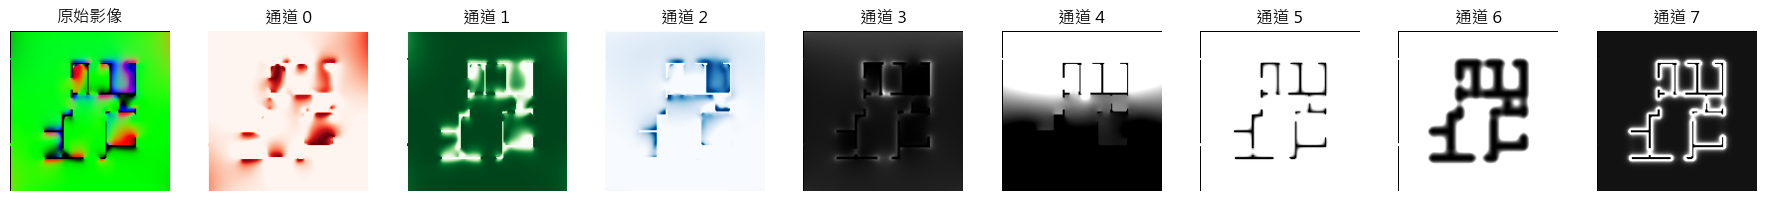

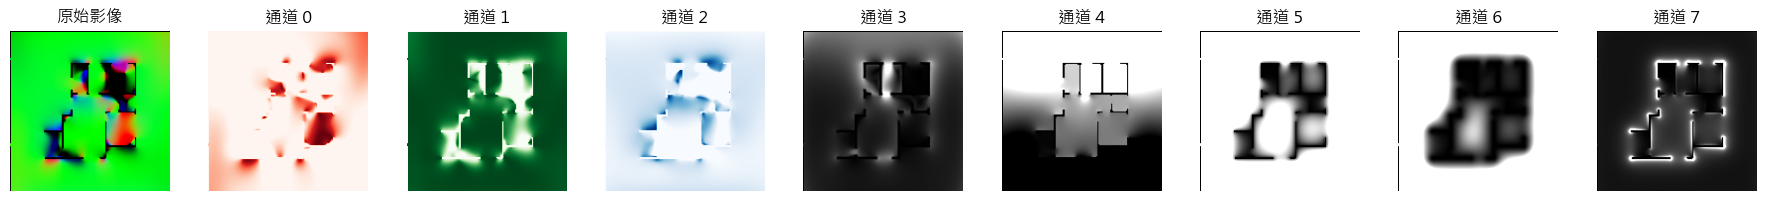

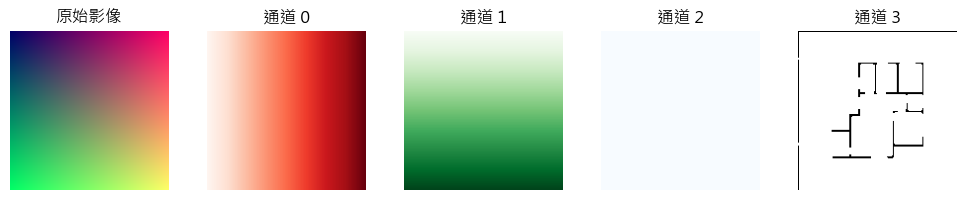

In [9]:
# 載入檔案
dynamic_fields = load_cfd_npy('../dataset/dynamic_fields.npy')
static_fields = load_cfd_npy('../dataset/static_fields.npy')[..., 3:] # 去除絕對座標XYZ

print(dynamic_fields.shape)
print(static_fields.shape)
plt_HWC_split_channels(dynamic_fields[0,16,:,:,:], histogram=False, max_channels=None)
plt_HWC_split_channels(dynamic_fields[-1,16,:,:,:], histogram=False, max_channels=None)
plt_HWC_split_channels(static_fields[16], histogram=False, max_channels=None)

In [10]:
def create_CFD_pool(pool_count =POOL_SIZE,  output_meta=False, total_c=CHANNEL_N):
    """
    取得一個批次的CFD 資料
    """
    t_slices, tn_slices, metadata = get_random_cfd_slices_pair(dynamic_fields, static_fields, slice_count=pool_count, output_meta=output_meta)
    t_slices = crop_and_resize(t_slices, (TARGET_SIZE,TARGET_SIZE), crop_size=2)
    tn_slices = crop_and_resize(tn_slices, (TARGET_SIZE,TARGET_SIZE), crop_size=2)

    new_order=[4,5,6,7,8,9,10,11,0,1,2,3]
    t_slices  = tf.gather(t_slices, indices=new_order, axis=-1)
    tn_slices = tf.gather(tn_slices, indices=new_order, axis=-1)

    t_slices = tf.reverse(t_slices, axis=[1])
    tn_slices = tf.reverse(tn_slices, axis=[1])



    hidden_channels = tf.zeros((pool_count, TARGET_SIZE, TARGET_SIZE, total_c - t_slices.shape[-1]), dtype=tf.float32)

    t_slices = tf.concat([t_slices, hidden_channels], axis=-1)
    tn_slices = tf.concat([tn_slices, hidden_channels], axis=-1)

    return t_slices, tn_slices, metadata

In [11]:
t_slices_pool, tn_slices_pool, metadata = create_CFD_pool(pool_count=POOL_SIZE, output_meta=True, total_c=CHANNEL_N)
CHANNEL_NAMES = [
        "X 方向速度", "Y 方向速度", "Z 方向速度", "流速大小", "壓力 p ", "湍流動能 k", "渦動黏滯係數 νₜ", "湍流能耗率 ε",
        "X 標準化座標", "Y 標準化座標", "Z 標準化座標", "遮罩",
]

print("t_slices_pool shape:", t_slices_pool.shape)
print("tn_slices_pool shape:", tn_slices_pool.shape)
print("metadata length:", len(metadata))


t_slices_pool shape: (256, 64, 64, 32)
tn_slices_pool shape: (256, 64, 64, 32)
metadata length: 256


### viz pool

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99988914..0.9999886].


random idx 121
{'t': 6, 'tn': 10, 'sz': 27, 'sy': 0, 'sx': 0}


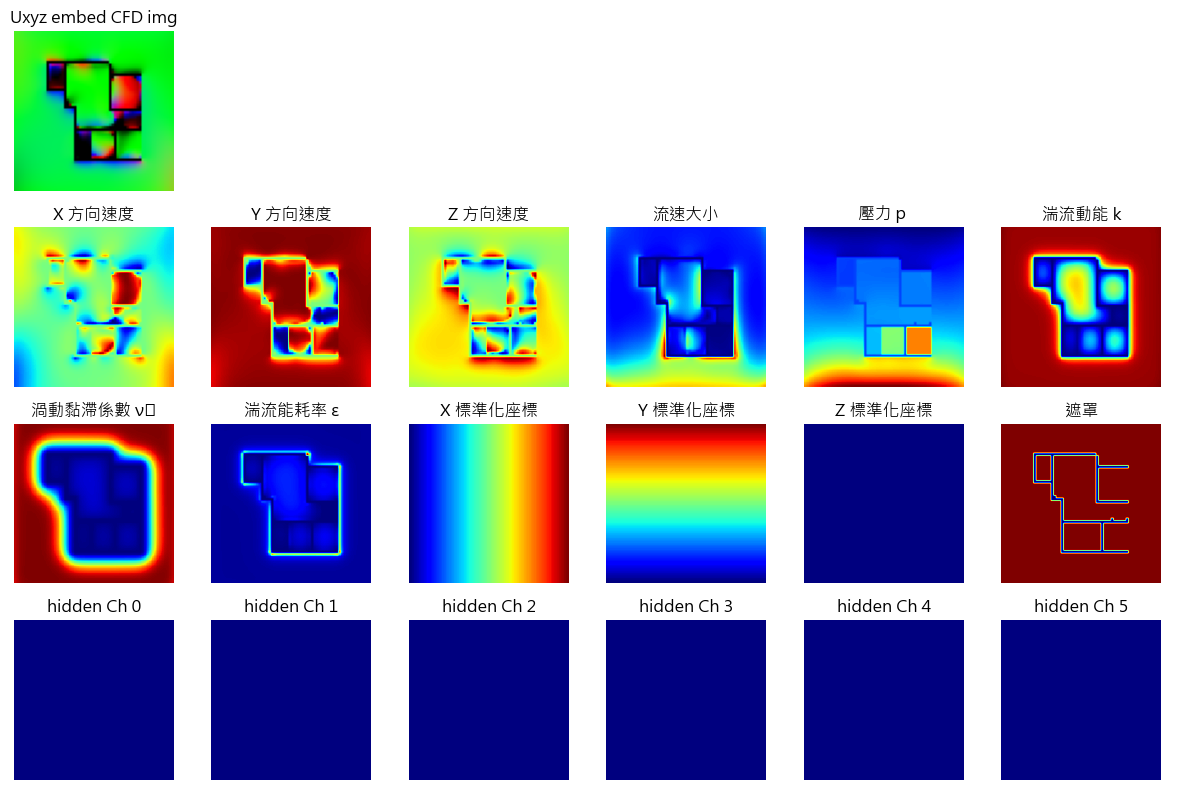

In [12]:
random_idx = np.random.randint(0, POOL_SIZE)
print("random idx", random_idx)
slice_data = metadata[random_idx]
print(slice_data)
t_title = f"CFD imgs for time {slice_data['t']} | xyz{slice_data['sx'],slice_data['sy'],slice_data['sz']} "
tn_title = f"CFD imgs for time {slice_data['tn']} | xyz{slice_data['sx'],slice_data['sy'],slice_data['sz']} "

plt_CFD_channels(t_slices_pool[random_idx], cols=6, histogram=False, channel_max=18, title=CHANNEL_NAMES)


# build Model

## func

## model

In [13]:


class CAModel(tf.keras.Model):

  def __init__(self, channel_n=CHANNEL_N):
    super().__init__()
    self.channel_n = channel_n
    self.dmodel = tf.keras.Sequential([
          layers.Conv2D(128, 1, activation=tf.nn.relu),
          layers.Conv2D(self.channel_n, 1, activation=None,
              kernel_initializer=tf.zeros_initializer),
    ])

    self(tf.zeros([1, 3, 3, channel_n]))  # dummy call to build the model

  @tf.function
  def perceive(self, x, angle=0.0):
    identify = np.float32([0, 1, 0])
    identify = np.outer(identify, identify)
    dx = np.outer([1, 2, 1], [-1, 0, 1]) / 8.0  # Sobel filter
    dy = dx.T
    c, s = tf.cos(angle), tf.sin(angle)
    kernel = tf.stack([identify, c*dx-s*dy, s*dx+c*dy], -1)[:, :, None, :]
    kernel = tf.repeat(kernel, self.channel_n, 2)
    y = tf.nn.depthwise_conv2d(x, kernel, [1, 1, 1, 1], 'SAME')
    return y

  @tf.function
  def call(self, x, n_times=1):
    for _ in range(n_times):
      x = self.forward_pass(x)
    return x
  
  @tf.function
  def forward_pass(self, x,angle=0.0):
    y = self.perceive(x, angle)
    dx = self.dmodel(y)
    x += dx 
    return x


CAModel().dmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (1, 3, 3, 128)            12416     
                                                                 
 conv2d_1 (Conv2D)           (1, 3, 3, 32)             4128      
                                                                 
Total params: 16,544
Trainable params: 16,544
Non-trainable params: 0
_________________________________________________________________


# Training

## make_circle_masks

In [14]:
@tf.function
def make_circle_masks(n, h, w):
  x = tf.linspace(-1.0, 1.0, w)[None, None, :]
  y = tf.linspace(-1.0, 1.0, h)[None, :, None]
  center = tf.random.uniform([2, n, 1, 1], -0.5, 0.5)
  r = tf.random.uniform([n, 1, 1], 0.1, 0.4)
  x, y = (x-center[0])/r, (y-center[1])/r
  mask = tf.cast(x*x+y*y < 1.0, tf.float32)
  return mask


## loss_fn

In [15]:
def loss_f(x, target=None):
  return tf.reduce_mean(tf.square(x[...,:8]-target[...,:8]), [-3, -2, -1])


## create_seed

In [16]:
def get_seed(idx):
    seed = np.zeros((BATCH_SIZE, TARGET_SIZE, TARGET_SIZE, CHANNEL_N), dtype=np.float32)
    tn_batch = tf.gather(tn_slices_pool, idx, axis=0).numpy()
    seed[..., :12] = tn_batch[..., 11:12]
    return seed

def get_tn(idx):
    tn_batch = tf.gather(tn_slices_pool, idx, axis=0)

    return tn_batch

def get_t(idx):
    t_batch = tf.gather(t_slices_pool, idx, axis=0).numpy()
    return t_batch

## init train

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99968976..0.99989885].


target shape: (1, 64, 64, 32)


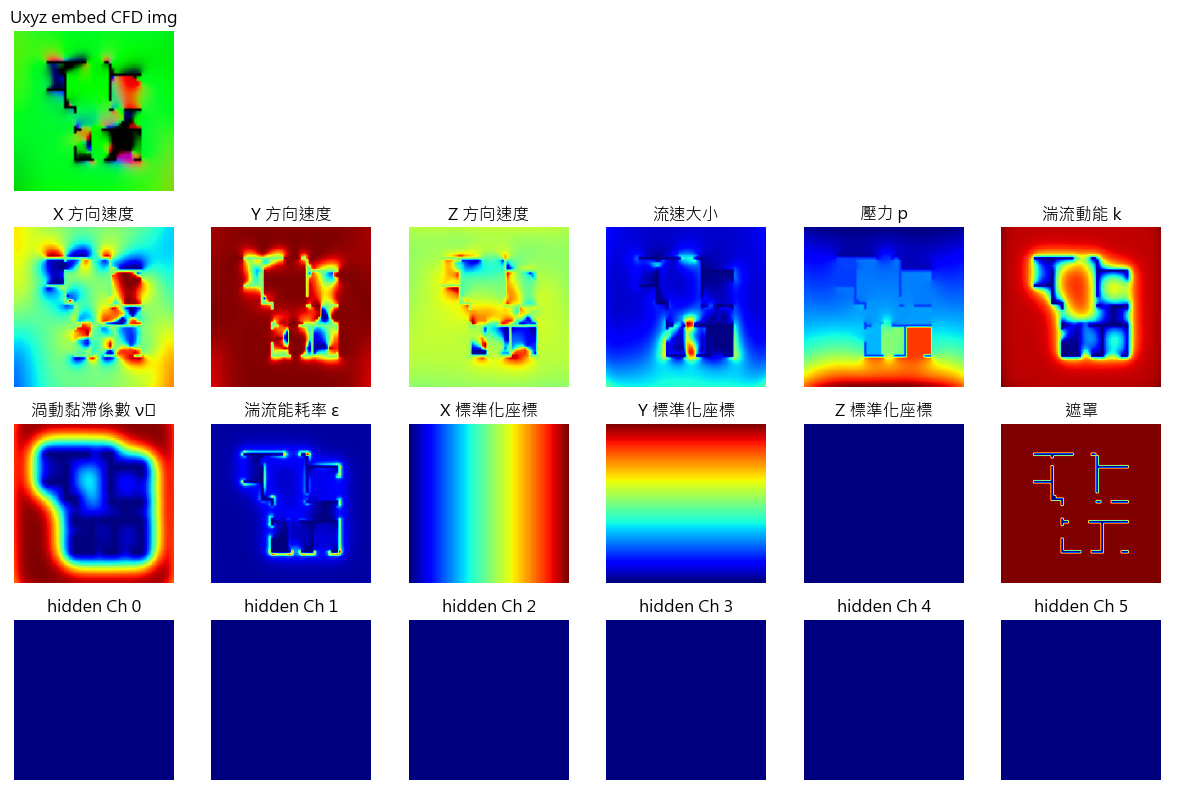

seed shape: (8, 64, 64, 32)


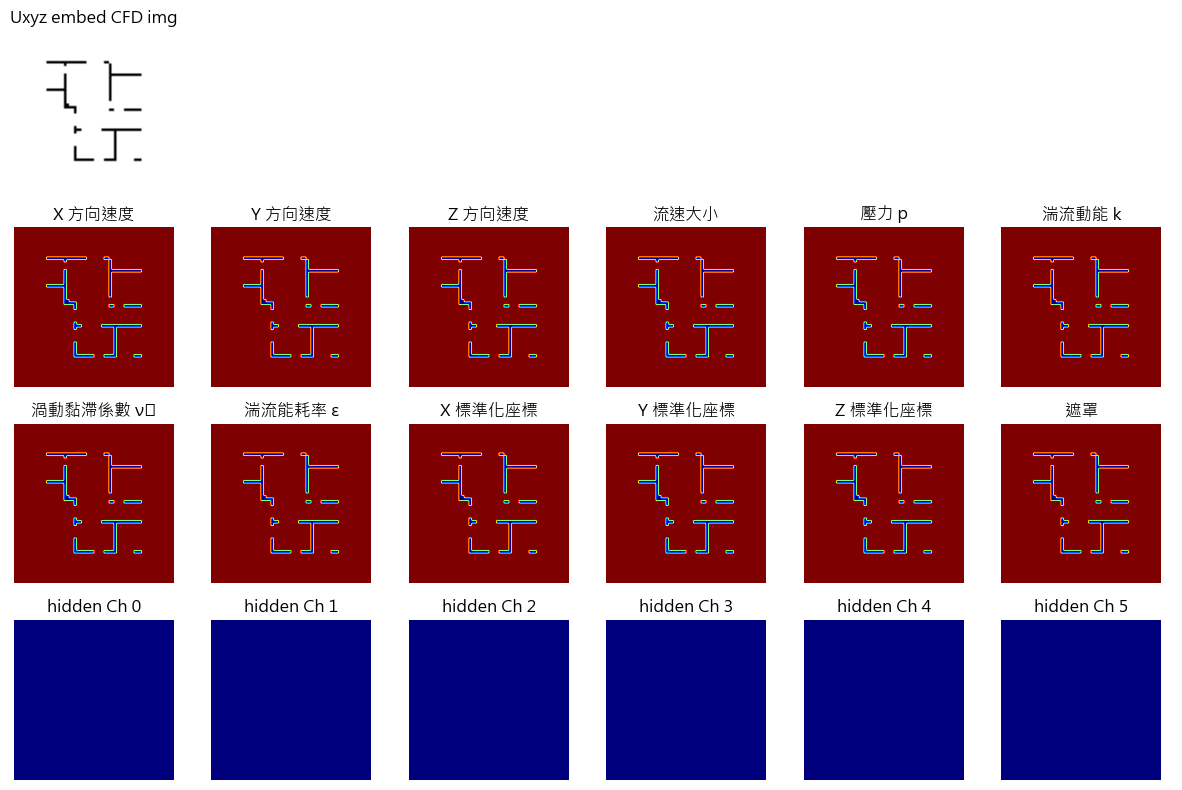

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9967263..0.99998206].


batch shape: (1, 64, 64, 32)


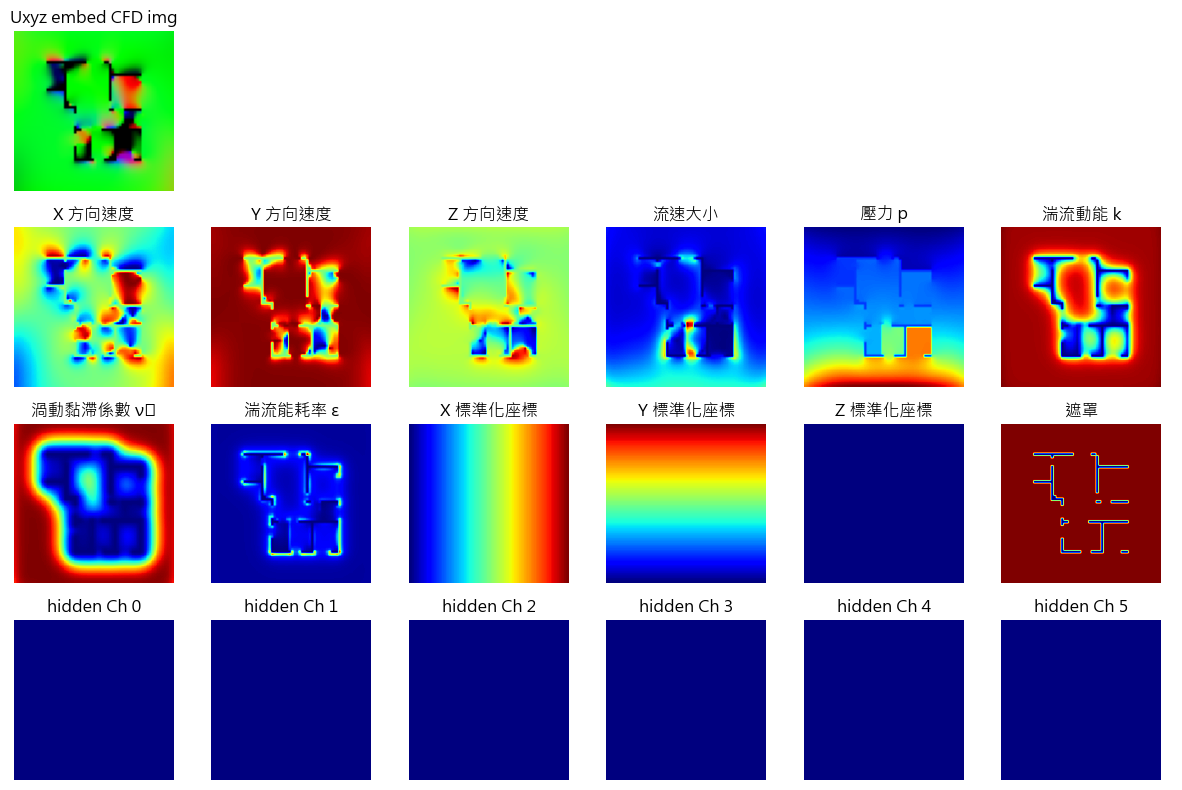

In [17]:
target = get_tn([0])
print("target shape:", target.shape)
plt_CFD_channels(target[0])

seed = get_seed([0])
print("seed shape:", seed.shape)
plt_CFD_channels(seed[0])

batch = get_t([0])
print("batch shape:", batch.shape)
plt_CFD_channels(batch[0])


# 取得 padding 後影像尺寸
height, width = target.shape[:2]

# 建立 NCA 模型實例
ca = CAModel()

# 設定學習率與階梯衰減學習率調度器
initial_lr = 2e-3
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[2000], values=[initial_lr, initial_lr * 0.1]
)


# 建立優化器，Adam
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# 初始損失（以種子推論一次損失）
loss0 = loss_f(seed, target).numpy()

# 編譯模型以便儲存完整訓練資訊
ca.compile(optimizer=optimizer, loss=loss_f)

# 建立 SamplePool，儲存多個種子作為訓練樣本池
data={
    'x': np.repeat(seed[None, ...], POOL_SIZE, axis=0)
}
pool = SamplePool(data)


## train step

In [ ]:
@tf.function
def train_step(x, target, model, loss_fn, optimizer):
  iter_n = tf.random.uniform([], 64, 96, tf.int32)
  with tf.GradientTape() as g:
    x = model(x, n_times=iter_n)
    loss = tf.reduce_mean(loss_fn(x, target))
  grads = g.gradient(loss, model.weights)
  grads = [g/(tf.norm(g)+1e-8) for g in grads]
  optimizer.apply_gradients(zip(grads, model.weights))
  return x, loss

In [ ]:
def export_model(ca, base_fn):
  ca.save_weights(base_fn)

  cf = ca.call.get_concrete_function(
      x=tf.TensorSpec([None, None, None, CHANNEL_N]),
      fire_rate=tf.constant(0.5),
      angle=tf.constant(0.0),
      step_size=tf.constant(1.0))
  cf = convert_to_constants.convert_variables_to_constants_v2(cf)
  graph_def = cf.graph.as_graph_def()
  graph_json = MessageToDict(graph_def)
  graph_json['versions'] = dict(producer='1.14', minConsumer='1.14')
  model_json = {
      'format': 'graph-model',
      'modelTopology': graph_json,
      'weightsManifest': [],
  }
  with open(base_fn+'.json', 'w') as f:
    json.dump(model_json, f)

## run train

In [ ]:
loss_log=[]
OUT_PATH = '../outputs/E3-1_CFD_NCA'
EPOCHS=4000+1

for i in range(EPOCHS+1):
  idx = tf.random.uniform(shape=(BATCH_SIZE,), minval=0, maxval=POOL_SIZE, dtype=tf.int32)

  x0 = get_batch(idx).numpy()
  target = get_target(idx)
  x0[:1] = get_seed(idx[0]).numpy()  # 保持第一個樣本為種子
  h,w = x0.shape[1:3]
  
  damage = 1.0-make_circle_masks(DAMAGE_N, h=h, w=w).numpy()[..., None]
  x0[-DAMAGE_N:] *= damage


  x, loss = train_step(x0, target, ca, loss_f, optimizer)


  pool= tf.tensor_scatter_nd_update(pool, idx, x0)

  step_i = len(loss_log)
  loss_log.append(loss.numpy())
 

  if step_i%10 == 0:
    viz_pool(pool, step_i, output_path=f'{OUT_PATH}/pool')

  if step_i%100 == 0 and step_i > 0:
    clear_output()
    viz_batch(x0, x, step_i, output_path=f'{OUT_PATH}/batch')
    if step_i == EPOCHS+1:
      viz_loss(loss_log, save_path=f'{OUT_PATH}')
    else:
      viz_loss(loss_log)
    ca.save(f'{OUT_PATH}/saved_model/{step_i}')
    
  print('\r step: %d, log10(loss): %.3f'%(len(loss_log), np.log10(loss)), end='')


ValueError: in user code:

    File "C:\Users\GAI\AppData\Local\Temp\ipykernel_34704\517820259.py", line 5, in train_step  *
        x = model(x, n_times=iter_n)
    File "c:\Users\GAI\anaconda3\envs\NCA_tf_gpu\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\GAI\AppData\Local\Temp\__autograph_generated_filewm6z4w28.py", line 23, in tf__call
        ag__.for_stmt(ag__.converted_call(ag__.ld(range), (ag__.ld(n_times),), None, fscope), None, loop_body, get_state, set_state, ('x',), {'iterate_names': '_'})
    File "C:\Users\GAI\AppData\Local\Temp\__autograph_generated_filewm6z4w28.py", line 21, in loop_body
        x = ag__.converted_call(ag__.ld(self).forward_pass, (ag__.ld(x),), None, fscope)
    File "C:\Users\GAI\AppData\Local\Temp\__autograph_generated_filesemuuzq_.py", line 10, in tf__forward_pass
        y = ag__.converted_call(ag__.ld(self).perceive, (ag__.ld(x), ag__.ld(angle)), None, fscope)
    File "C:\Users\GAI\AppData\Local\Temp\__autograph_generated_fileom0q9rpu.py", line 17, in tf__perceive
        y = ag__.converted_call(ag__.ld(tf).nn.depthwise_conv2d, (ag__.ld(x), ag__.ld(kernel), [1, 1, 1, 1], 'SAME'), None, fscope)

    ValueError: Exception encountered when calling layer "ca_model_5" "                 f"(type CAModel).
    
    in user code:
    
        File "C:\Users\GAI\AppData\Local\Temp\ipykernel_34704\797252367.py", line 29, in call  *
            x = self.forward_pass(x)
        File "C:\Users\GAI\AppData\Local\Temp\ipykernel_34704\797252367.py", line 34, in forward_pass  *
            y = self.perceive(x, angle)
        File "C:\Users\GAI\AppData\Local\Temp\ipykernel_34704\797252367.py", line 23, in perceive  *
            y = tf.nn.depthwise_conv2d(x, kernel, [1, 1, 1, 1], 'SAME')
    
        ValueError: Dimensions must be equal, but are 12 and 32 for '{{node depthwise}} = DepthwiseConv2dNative[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="SAME", strides=[1, 1, 1, 1]](x, Repeat/Reshape_1)' with input shapes: [8,64,64,12], [3,3,32,3].
    
    
    Call arguments received by layer "ca_model_5" "                 f"(type CAModel):
      • x=tf.Tensor(shape=(8, 64, 64, 12), dtype=float32)
      • n_times=tf.Tensor(shape=(), dtype=int32)


# Figures

In [ ]:
models = []
for i in [100, 500, 1000, 2000, 4000]:
  loaded_ca = tf.keras.models.load_model(f'{OUT_PATH}/saved_model/{i}',
                                         custom_objects={'loss_f': loss_f, 'CAModel': CAModel, 'to_rgba': to_rgba})
  models.append(loaded_ca)

out_fn = f'{OUT_PATH}/video/trained_for_differnt_steps.mp4'

# 自動建立資料夾
out_dir = os.path.dirname(out_fn)
os.makedirs(out_dir, exist_ok=True)

x = np.zeros([len(models), 72, 72, CHANNEL_N], np.float32)
x[..., 36, 36, 3:] = 1.0
with VideoWriter(out_fn) as vid:
  for i in tqdm.trange(500):
    if i%50==0:
        damage = 1.0-make_circle_masks(DAMAGE_N, h=h, w=w).numpy()[..., None]
        x[-DAMAGE_N:] *= damage
    vis = np.hstack(to_rgb(x))
    vid.add(zoom(vis, 2))
    for loaded_ca, xk in zip(models, x):
      xk[:] = loaded_ca(xk[None,...])[0]
mvp.ipython_display(out_fn)

100%|██████████| 500/500 [00:08<00:00, 58.54it/s]


In [ ]:
#@title Training Progress (Batches)
video_path = f'{OUT_PATH}/video/batches.mp4'
frames = sorted(glob.glob(f'{OUT_PATH}/batch/batches_*.jpg'))
mvp.ImageSequenceClip(frames, fps=10.0).write_videofile(video_path)
mvp.ipython_display(video_path)

Moviepy - Building video ../outputs/E1_3-GNCA/video/batches.mp4.
Moviepy - Writing video ../outputs/E1_3-GNCA/video/batches.mp4



Moviepy - Done !
Moviepy - video ready ../outputs/E1_3-GNCA/video/batches.mp4


In [ ]:
#@title Pool Contents
video_path = f'{OUT_PATH}/video/pools.mp4'
frames = sorted(glob.glob(f'{OUT_PATH}/pool/*_pool.jpg'))[:80]
mvp.ImageSequenceClip(frames, fps=20.0).write_videofile(video_path)
mvp.ipython_display(video_path)

Moviepy - Building video ../outputs/E1_3-GNCA/video/pools.mp4.
Moviepy - Writing video ../outputs/E1_3-GNCA/video/pools.mp4



Moviepy - Done !
Moviepy - video ready ../outputs/E1_3-GNCA/video/pools.mp4
